In [5]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import category_encoders as ce   # https://contrib.scikit-learn.org/category_encoders/
import xgboost as xgb

from sklearn.utils import check_random_state
from sklearn.datasets import make_friedman1, make_friedman3
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from category_encoders.wrapper import NestedCVWrapper
from pathlib import Path
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping
sys.path.append("../")
from glmmnet import build_glmmnet, predict_glmmnet, build_baseline_nn
from utils import split, evaluate_model, evaluate_predictions, embedding_preproc

In [7]:
def make_sim4(n_samples=100, noise=0.0, random_state=None):
    """Generate synthetic regression data.
    Inputs `X` are 8 independent features uniformly distributed on the
    intervals::
        0 <= X[:, 0] <= 1,
        0 <= X[:, 1] <= 1,
        0 <= X[:, 2] <= 1,
        0 <= X[:, 3] <= pi,
        0 <= X[:, 4] <= 1,
        0 <= X[:, 5] <= 100 * pi,
        0 <= X[:, 6] <= 1/2,
        0 <= X[:, 7] <= 1/2.
    The output `y` is created according to the formula::
        y(X) = sinh(X[:, 0] + X[:, 1]) + arccos(tanh(X[:, 2] + X[:, 3] \
            + X[:, 4])) + cos(X[:, 3] + X[:, 5]) + sec(X[:, 6] + X[:, 7]) \
            + noise * N(0, 1).
    Adapted from http://www-scf.usc.edu/~tsangm/papers/nid_slides.pdf

    Parameters
    ----------
    n_samples : int, default=100
        The number of samples.
    noise : float, default=0.0
        The standard deviation of the gaussian noise applied to the output.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset noise. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : ndarray of shape (n_samples, 8)
        The input samples.
    y : ndarray of shape (n_samples,)
        The output values.
    """
    rng = check_random_state(random_state)

    X = rng.uniform(size=(n_samples, 8))
    X[:, 3] *= np.pi
    X[:, 5] *= 100 * np.pi
    X[:, 6] *= 1/2
    X[:, 7] *= 1/2
    y = (np.sinh(X[:, 0] + X[:, 1]) + np.arccos(np.tanh(X[:, 2] + X[:, 3] + X[:, 4])) +
         np.cos(X[:, 3] + X[:, 5]) + 1 / np.cos(X[:, 6] + X[:, 7])) + noise * rng.standard_normal(size=(n_samples))

    return X, y


In [8]:
def make_sim5(n_samples=100, noise=0.0, random_state=None):
    """Generate synthetic regression data.
    Inputs `X` are 8 independent features uniformly distributed on the
    intervals::
        0 <= X[:, 0] <= 1,
        0 <= X[:, 1] <= 1,
        0 <= X[:, 2] <= 4,
        0 <= X[:, 3] <= 1/4,
        0 <= X[:, 4] <= 2,
        0 <= X[:, 5] <= 1/2,
        0 <= X[:, 6] <= 1,
        0 <= X[:, 7] <= 1.
    The output `y` is created according to the formula::
        y(X) = exp(abs(X[:, 0] - X[:, 1])) + abs(X[:, 2] * X[:, 3]) \
            - [X:, 3] ** [X:, 4] + log(X[:, 4] ** 2 + X[:, 5] ** 2) \
            + X[:, 6] + 1 / (1 + X[:, 7] ** 2) + noise * N(0, 1).
    Adapted from http://www-scf.usc.edu/~tsangm/papers/nid_slides.pdf

    Parameters
    ----------
    n_samples : int, default=100
        The number of samples.
    noise : float, default=0.0
        The standard deviation of the gaussian noise applied to the output.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset noise. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : ndarray of shape (n_samples, 8)
        The input samples.
    y : ndarray of shape (n_samples,)
        The output values.
    """
    rng = check_random_state(random_state)

    X = rng.uniform(size=(n_samples, 8))
    X[:, 2] *= 4
    X[:, 3] *= 1/4
    X[:, 4] *= 2
    X[:, 5] *= 1/2
    y = (np.exp(np.abs(X[:, 0] - X[:, 1])) + np.abs(X[:, 2] * X[:, 3]) -
            X[:, 3] ** X[:, 4] + np.log(X[:, 4] ** 2 + X[:, 5] ** 2) +
            X[:, 6] + 1 / (1 + X[:, 7] ** 2)) + noise * rng.standard_normal(size=(n_samples))

    return X, y


In [9]:
def make_sim(
        X, f_X, n_categories, signal_to_noise=np.array([4, 2, 1]),
        y_dist="gaussian", inverse_link=None, cat_dist="balanced", random_state=None):
    """
    Generate synthetic regression data from mixed effects models:
        `g(mu) = f(X) + Z*u`,
    where `f(X)` is a nonlinear function of `X` (feature matrix), `Z` is 
    a matrix of random effects variables, `u` is a vector of random effects,
    and `g(mu)` is a nonlinear function of `mu` (mean response).

    Parameters
    ----------
    X : feature matrix of fixed effects, pd.DataFrame of shape (n_samples, n_features).
    f_X : nonlinear deterministic function of `X`, ndarray of shape (n_samples, ).
    n_categories : int, number of categories/groups.
    signal_to_noise : ndarray of shape (3, ), default=np.array([4, 2, 1])
        The relative ratio of signal from fixed effects, signal from random effects, 
        and noise in the response. It will be normalized to sum to 1.
    y_dist : str, default="gaussian"
        The distribution of the response variable, "gaussian", "gamma", or "lognormal".
    inverse_link : callable, inverse of link function.
        If None, the exp function is used when y_dist="gamma", and the identity function
        is used otherwise.
    cat_dist : str, default="balanced"
        "balanced" or "skewed" distributions for the allocation of categories.
        "balanced" allocates approx equal number of observations to each category.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset noise. Pass an int
        for reproducible output across multiple function calls.
    
    Returns
    -------
    X : pd.DataFrame of shape (n_samples, n_features + 1).
        The input samples, including a column of category labels from 0 to n_categories-1.
    y : ndarray of shape (n_samples,)
        The output values.
    truth : ndarray of shape (n_samples,)
        The true mean response values (unobservable in practice).
    Zu : ndarray of shape (n_samples,)
        The raw random effects.
    """
    rng = check_random_state(random_state)
    n_samples = X.shape[0]
    n_features = X.shape[1]
    X = pd.DataFrame(X, columns=["X" + str(i) for i in range(1, n_features + 1)])
    if (cat_dist == "balanced"):
        X = X.assign(
            # Generate a random number from 0 to (n_categories - 1)
            category = rng.randint(low=0, high=n_categories, size=n_samples).astype(object)
        )
    elif (cat_dist == "skewed"):
        X = X.assign(
            category = np.floor(rng.beta(a=2, b=3, size=n_samples) * n_categories).astype(int).astype(object)
        )
    
    # Generate random effects
    signal_to_noise = signal_to_noise / sum(signal_to_noise)
    signal_FE, signal_RE, noise = tuple(signal_to_noise)
    u = rng.standard_normal(size=n_categories) * signal_RE
    Zu = u[X.category.astype(int)]

    # Scale the fixed effects so that the mean of f(X) = signal_FE
    f_X = f_X / f_X.mean() * signal_FE

    # Generate response variable
    if inverse_link is None:
        # By default, use log link for gamma and identity link for lognormal or gaussian
        inverse_link = np.exp if y_dist == "gamma" else (lambda x: x)
    truth = inverse_link(f_X + Zu)
    if (y_dist == "gaussian"):
        y = rng.normal(loc=truth, scale=noise, size=n_samples)
    elif (y_dist == "gamma"):
        # We need:
        # 1. gamma_mean = truth, i.e. gamma_shape * gamma_scale = truth
        # 2. gamma_variance = (noise ** 2) * (truth ** 2), where gamma_variance = gamma_mean ** 2 / gamma_shape
        gamma_shape = 1 / (noise ** 2)
        gamma_scale = (noise ** 2) * truth
        y = rng.gamma(shape=gamma_shape, scale=gamma_scale, size=n_samples)
    elif (y_dist == "lognormal"):
        # 1. ln_mean = truth
        # 2. ln_variance = noise ** 2
        ln_sigma = np.sqrt(np.log(1 + (noise ** 2) / (truth ** 2)))
        ln_mean = np.log(truth) - ln_sigma ** 2 / 2
        y = rng.lognormal(mean=ln_mean, sigma=ln_sigma, size=n_samples)
    
    return X, y, truth, Zu

In [10]:
def generate_data(
        exp_id, n_train=5000, n_test=2500, n_categories=100, f_structure="friedman1",
        signal_to_noise=np.array([4, 2, 1]), y_dist="gaussian", inverse_link=lambda x: x, 
        cat_dist="balanced", random_state=None, overwrite="auto", suffix=""):
    """
    Generate synthetic regression data from mixed effects models:
        `g(mu) = f(X) + Z*u`,
    where `f(X)` is a nonlinear function of `X` given by `f_structure`, `Z` is 
    a matrix of random effects variables, `u` is a vector of random effects,
    and `g(mu)` is a nonlinear function of `mu` (mean response).

    Parameters
    ----------
    exp_id : int, experiment id.
    n_train : int, number of training samples.
    n_test : int, number of test samples.
    n_categories : int, number of categories.
    f_structure : str, structure of f(X), choose from "friedman1" (default), "friedman3".
    signal_to_noise : ndarray of shape (3, ), default=np.array([4, 2, 1])
        The relative ratio of signal from fixed effects, signal from random effects, 
        and noise in the response. It will be normalized to sum to 1.
    y_dist : str, default="gaussian"
        The distribution of the response variable, "gaussian", "gamma", or "lognormal".
    inverse_link : callable, inverse of link function.
        If None, the exp function is used when y_dist="gamma", and the identity function
        is used otherwise.
    cat_dist : str, default="balanced"
        "balanced" or "skewed" distributions for the allocation of categories.
        "balanced" allocates approx equal number of observations to each category.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset noise. Pass an int
        for reproducible output across multiple function calls.
    overwrite : bool, default="auto"
        Whether to overwrite existing data. If "auto", it will be set to True if
        the data does not exist, and False otherwise.
    suffix : str, default=""
        Suffix to append to the file name.
    
    Returns
    -------
    A dictionary of dataframes, with keys "train", "test", "Zu".
    """
    n = n_train + n_test
    if (f_structure == "friedman1"):
        # Out of the n_features features, only 5 are actually used to compute y.
        # The remaining features are independent of y.
        X, f_X = make_friedman1(n_samples=n, n_features=10, noise=0.0, random_state=random_state)
    elif (f_structure == "friedman3"):
        X, f_X = make_friedman3(n_samples=n, noise=0.0, random_state=random_state)

    # Simulate random effects and therefore the response variable y
    X, y, truth, Zu = make_sim(X, f_X, n_categories, signal_to_noise, y_dist, inverse_link, cat_dist, random_state)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = split(X, y, n_train)

    # Conditional mean true values (unobservable in practice)
    y_true_train = truth[:n_train]
    y_true_test = truth[n_train:]

    # Combine X, y, and truth into a dataframe and save to files
    train_data = pd.concat([
        X_train.reset_index(drop=True), 
        pd.DataFrame(y_train, columns=["y"]), 
        pd.DataFrame(y_true_train, columns=["y_true"])], axis=1)
    test_data = pd.concat([
        X_test.reset_index(drop=True),
        pd.DataFrame(y_test, columns=["y"]),
        pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)

    path = f"data/experiment_{exp_id}"
    if (overwrite == "auto"):
        overwrite = not Path(f"{path}/train_data{suffix}.csv").exists()
    if (overwrite):
        train_data.to_csv(f"{path}/train_data{suffix}.csv", index=False)
        test_data.to_csv(f"{path}/test_data{suffix}.csv", index=False)
    
    return {
        "train": (X_train, y_train, y_true_train),
        "test": (X_test, y_test, y_true_test),
        "Zu": Zu,
    }


In [16]:
# Make a function to run simulation experiments similar to run_sim_experiment in the demo notebook
# This is a lighter version that only computes the test (and no training) performance
# Requires saved experiment results for GLMM and GPBoost (see R script)
def run_sim_experiment_light(exp_id, sim_data, y_dist="gaussian", random_state=42, suffix=""):

    # Unpack data
    X_train, y_train, y_true_train = sim_data["train"]
    X_test, y_test, y_true_test = sim_data["test"]
    Zu = sim_data["Zu"]

    # Variable names
    hicard_var = "category"
    x_num = [col for col in X_train.columns if col not in hicard_var]
    colnames = [hicard_var] + x_num

    # Convert numeric to string so they can be recognised by ce.OrdinalEncoder
    X_train[hicard_var] = X_train[hicard_var].astype("str")
    X_test[hicard_var] = X_test[hicard_var].astype("str")

    # Initialise
    test_scores = dict()

    # GLM
    # -------------------------------------------------------------------------
    ignore_cat_encoder = make_column_transformer(
        ("drop", [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_ic = ignore_cat_encoder.fit_transform(X_train)
    X_test_ic = ignore_cat_encoder.transform(X_test)
    if y_dist == "gaussian":
        GLM_ignore_cat = LinearRegression()
        GLM_ignore_cat.fit(X_train_ic, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_ignore_cat = sm.GLM(y_train, X_train_ic, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_ignore_cat.scale
    test_scores["GLM_ignore_cat"] = evaluate_model(
        GLM_ignore_cat, X_test_ic, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)

    one_hot_encoder = make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_ohe = one_hot_encoder.fit_transform(X_train)
    X_test_ohe = one_hot_encoder.transform(X_test)
    if y_dist == "gaussian":
        GLM_one_hot = LinearRegression()
        GLM_one_hot.fit(X_train_ohe, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_one_hot = sm.GLM(y_train, X_train_ohe, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_one_hot.scale
    test_scores["GLM_one_hot"] = evaluate_model(
        GLM_one_hot, X_test_ohe, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)

    GLMM_encoder = make_column_transformer(
        # https://contrib.scikit-learn.org/category_encoders/wrapper.html
        (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
        (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
    )
    X_train_GLMM_enc = GLMM_encoder.fit_transform(X_train, y_train)
    X_test_GLMM_enc = GLMM_encoder.transform(X_test)
    if y_dist == "gaussian":
        GLM_GLMM_enc = LinearRegression()
        GLM_GLMM_enc.fit(X_train_GLMM_enc, y_train)
        gamma_shape = None # placeholder, will not be read when y_dist == "gaussian"
    elif y_dist == "gamma":
        GLM_GLMM_enc = sm.GLM(y_train, X_train_GLMM_enc, family=sm.families.Gamma(sm.families.links.log())).fit()
        gamma_shape = 1 / GLM_GLMM_enc.scale
    test_scores["GLM_GLMM_enc"] = evaluate_model(
        GLM_GLMM_enc, X_test_GLMM_enc, y_test, categories=X_test[hicard_var], 
        likelihood=y_dist, gamma_shape=gamma_shape)
 # GBM
    # -------------------------------------------------------------------------
    GBM_ignore_cat = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    GBM_ignore_cat.fit(X_train_ic, y_train)
    test_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_test_ic, y_test, categories=X_test[hicard_var], likelihood=y_dist)

    GBM_one_hot = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    GBM_one_hot.fit(X_train_ohe, y_train)
    test_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_test_ohe, y_test, categories=X_test[hicard_var], likelihood=y_dist)

    GBM_GLMM_enc = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    GBM_GLMM_enc.fit(X_train_GLMM_enc, y_train)
    test_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_test_GLMM_enc, y_test, categories=X_test[hicard_var], likelihood=y_dist)
     # NN with entity embeddings
    # -------------------------------------------------------------------------
    ct_nn = make_column_transformer(
        (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
        (MinMaxScaler(feature_range=(0, 1)), x_num),
    )
    X_train_ct = pd.DataFrame(ct_nn.fit_transform(X_train), columns=colnames)
    X_test_ct = pd.DataFrame(ct_nn.transform(X_test), columns=colnames)
    X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

    # Define training parameters
    epochs = 500
    patience = 50
    batch_size = 256
    NN_ee = build_baseline_nn(X_train_ct, random_state=random_state, num_vars=x_num, cat_vars=[hicard_var])
    es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)

    hist = NN_ee.fit(
        (tuple(X_embed_train), X_train_ct[x_num]), y_train, validation_split=0.2, 
        epochs=epochs, callbacks=[es], batch_size=batch_size, verbose=0)
    y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()
    test_scores["NN_ee"] = evaluate_predictions(y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist)

    # Extract embeddings from the fitted neural network model
    embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
    embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
    oe = ct_nn.named_transformers_["ordinalencoder"]
    categories = np.array(oe.category_mapping[0]["mapping"])[:-1]
    embeddings = pd.concat([pd.DataFrame(categories, columns=[hicard_var]), embeddings], axis=1)

    # GBM with entity embeddings
    # -------------------------------------------------------------------------
    # .fillna(0) fills zeros for missing values in the embeddings (i.e. unknown categories)
    X_train_ee = pd.merge(X_train_ct, embeddings, on="category", how="left").drop("category", axis=1)
    X_test_ee = pd.merge(X_test_ct, embeddings, on="category", how="left").drop("category", axis=1).fillna(0)
    GBM_ee = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_state)
    GBM_ee.fit(X_train_ee, y_train)
    test_scores["GBM_ee"] = evaluate_model(GBM_ee, X_test_ee, y_test, categories=X_test[hicard_var], likelihood=y_dist)

    # GLMM
    # -------------------------------------------------------------------------
    y_pred_test_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_pred_test{suffix}.csv").values.reshape(-1)
    sigma_brms = pd.read_csv(f"models/experiment_{exp_id}/brms_sigma{suffix}.csv").values.reshape(-1)
    if y_dist == "gaussian":
        custom_params_test = {"loc": y_pred_test_brms, "scale": sigma_brms}
    elif y_dist == "gamma":
        custom_params_test = {"gamma_shape": sigma_brms, "gamma_scale": y_pred_test_brms / sigma_brms}
    test_scores["GLMM"] = evaluate_predictions(
        y_test, y_pred_test_brms, categories=X_test[hicard_var], likelihood=y_dist,
        **custom_params_test
    )
    
    # GPBoost
    # -------------------------------------------------------------------------
    y_pred_test_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_pred_test{suffix}.csv").values.reshape(-1)
    scale_gpb = pd.read_csv(f"models/experiment_{exp_id}/gpboost_scale{suffix}.csv").values.reshape(-1)
    test_scores["GPBoost"] = evaluate_predictions(
        y_test, y_pred_test_gpb, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test_gpb, scale=np.sqrt(scale_gpb),
    )

    # GLMMNet (proposed model)
    # -------------------------------------------------------------------------
    set_seed(random_state)
    one_hot = ce.OneHotEncoder(cols=[hicard_var], handle_unknown="value")
    X_train_ct_ohe = one_hot.fit_transform(X_train_ct)
    X_test_ct_ohe = one_hot.transform(X_test_ct)
    cardinality = len(one_hot.category_mapping[0]["mapping"].keys()) - 1

    glmmnet = build_glmmnet(
        cardinality=cardinality, num_vars=x_num, final_layer_likelihood=y_dist, 
        train_size=X_train.shape[0], random_state=random_state)
    es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
    hist = glmmnet.fit(
        (X_train_ct.drop([hicard_var], axis=1), X_train_ct_ohe.loc[:, X_train_ct_ohe.columns.str.startswith(hicard_var)]), y_train, 
        validation_split=0.2,
        callbacks=[es],
        # batch_size = 128 or 256 doesn't make a difference here, but 256 is faster
        batch_size=256, epochs=500, verbose=False)

    y_pred_test = predict_glmmnet(glmmnet, X_test_ct_ohe, hicard_var)
    phi = glmmnet.get_layer("dist_params").get_weights()
    test_scores["GLMMNet"] = evaluate_predictions(
        y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test, scale=phi[0][0], gamma_shape=1 / phi[0][0])

    # GLMMNet with l2-regularizer
    # -------------------------------------------------------------------------
    glmmnet_l2 = build_glmmnet(
        cardinality=cardinality, num_vars=x_num, final_layer_likelihood=y_dist, 
        train_size=X_train.shape[0], random_state=random_state, regularizer=True)
    es = EarlyStopping(patience=50, restore_best_weights=True, monitor="val_loss", verbose=2)
    hist = glmmnet_l2.fit(
        (X_train_ct.drop([hicard_var], axis=1), X_train_ct_ohe.loc[:, X_train_ct_ohe.columns.str.startswith(hicard_var)]), y_train, 
        validation_split=0.2,
        callbacks=[es],
        # batch_size = 128 or 256 doesn't make a difference here, but 256 is faster
        batch_size=256, epochs=500, verbose=False)

    y_pred_test = predict_glmmnet(glmmnet_l2, X_test_ct_ohe, hicard_var)
    phi = glmmnet_l2.get_layer("dist_params").get_weights()
    test_scores["GLMMNet_l2"] = evaluate_predictions(
        y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist,
        loc=y_pred_test, scale=phi[0][0], gamma_shape=1 / phi[0][0])
    
    return test_scores


sim4: 

0.20506709735851436 6.523938859353687 2.698854347830454


sim5: 

-5.766023769354329 6.673197333061368 2.5450551279197904


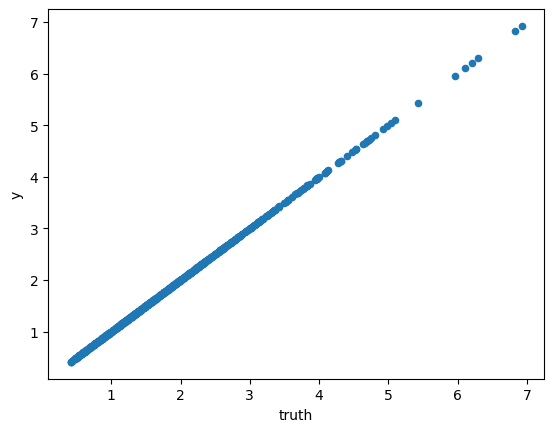

In [17]:
if __name__ == '__main__':

    X, F = make_sim4(n_samples=10000)
    print("sim4: \n")
    # print(X[:10, :])
    print(F.min(), F.max(), F.mean())
    print("\n")

    X, F = make_sim5(n_samples=10000)
    print("sim5: \n")
    # print(X[:10, :])
    print(F.min(), F.max(), F.mean())

    X, F = make_friedman1(n_samples=1000, n_features=10, random_state=42)
    stn = np.array([1, 1, 1e-3])
    X, y, truth, Zu = make_sim(X, F, y_dist="lognormal", inverse_link=np.exp, n_categories=100, signal_to_noise=stn, random_state=42)
    # Check plot in an interactive environment
    # When stn[2] == 0, the plot should be a straight line
    _ = pd.DataFrame({"truth": truth, "y": y}).plot.scatter(x="truth", y = "y")